# YouTube Spam Comment Classification

This project focuses on developing a machine learning model to classify YouTube comments as either "Spam" or "Not Spam." With the increasing number of user-generated comments on YouTube, it becomes crucial to detect and manage spam comments efficiently. This classifier uses a RandomForestClassifier and TF-IDF Vectorizer to process text data and make predictions.

## Prepare Data

### Import

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

**Task 1.0**: Load a CSV file containing YouTube comment data and display the first few rows of the dataset.

The code uses the `pandas` library to read a CSV file located at a specific path and store it in a DataFrame named `df`. The `df.head()` function is then called to display the first five rows of the DataFrame, which allows for a quick look at the structure and contents of the dataset.

In [2]:
df = pd.read_csv("/Users/anoop/Downloads/Youtube-Spam-Dataset.csv") 
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


### Explore

**Task 1.1**: Define a set of **stop words** to remove common and irrelevant words from YouTube comment data.

The code defines a set of common English stop words, along with additional words specific to the context of YouTube comments (like 'guys,' 'vid,' 'vids,' 'hey,' and 'u'). 

Stop words are often removed in natural language processing (NLP) tasks because they do not contribute meaningful information for classification or analysis. By eliminating these words, the model can focus on more relevant content, improving its ability to differentiate between spam and non-spam comments.

In [3]:
stop_words = {
    'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't",
    'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn',
    "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down',
    'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
    "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into',
    'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more',
    'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on',
    'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't",
    'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll",
    'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to',
    'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when',
    'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you',
    "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves', 'guys', 'vid', 'vids', 'hey', 'u'
}

**Task 1.2**: Define a function to clean and preprocess YouTube comment text by removing unnecessary elements and improving data quality for the classification model.

This `clean_comment` function performs several important steps to clean and preprocess text data, such as removing URLs, punctuation, special characters, numbers, and extra spaces. It also converts text to lowercase and removes common stop words. 

Text cleaning is crucial for machine learning models because raw text often contains noise and irrelevant information. By cleaning the data, this function helps the model focus on meaningful words, improving its ability to accurately classify comments as spam or not.

In [4]:
def clean_comment(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)  # \W matches any non-word character
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Convert to lowercase
    text = text.lower()

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

**Task 1.3**: Apply the text cleaning function to all comments in the dataset and create a new column for the cleaned comments.

The following code applies the `clean_comment` function to each value in the `CONTENT` column of the DataFrame `df`, which contains the raw YouTube comments. The cleaned text is stored in a new column named `cleaned_comments`. 

This step ensures that all the comments in the dataset are properly cleaned and preprocessed before they are used for further analysis or model training, improving the overall quality and accuracy of the classification task.

In [5]:
df["cleaned_comments"] = df["CONTENT"].apply(clean_comment)
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS,cleaned_comments
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1,huh anyway check tube channel kobyoshi
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1,check new channel first us monkeys monkey whit...
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1,test say murdev com
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1,shaking sexy ass channel enjoy _
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1,watch v vtarggvgtwq check


### Split

**Task 1.4**: Define the feature and target variables for the classification model.

The code given below sets big `X` to the values in the `cleaned_comments` column, which contains the preprocessed YouTube comments, and little `y` to the values in the `CLASS` column, which represents whether a comment is spam (1) or not spam (0). 

The feature variable `X` contains the input data, while the target variable `y` contains the labels that the model will try to predict during the classification task. This step organizes the data for model training and evaluation.

In [6]:
feature = "cleaned_comments"
target = "CLASS"

X = df[feature]
y = df[target]

print(X.shape)
print(y.shape)

(1956,)
(1956,)


**Task 1.5**: Split the dataset into training and testing sets to prepare for model training and evaluation.

The following code splits the `X` (feature) and `y` (target labels) into training and testing sets using an 80-20 split. `train_test_split` ensures that 80% of the data is used to train the model (`X_train`, `y_train`), and 20% is reserved for testing (X_test, y_test). The `random_state=42` ensures the split is reproducible.

The train-test split is essential for evaluating how well the model generalizes to unseen data. By training the model on one part of the dataset and testing it on another, we can assess its real-world performance and avoid overfitting, where the model might memorize the training data but fail on new data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (1564,)
Test data shape: (392,)


**Task 1.6**: Establish a baseline accuracy to evaluate model performance.

The baseline accuracy represents the accuracy we would achieve by always predicting the most frequent class (either spam or not spam) in the training dataset. It's a simple metric used to compare how well our classification model performs. For our model to be useful, it must achieve an accuracy higher than this baseline.

By calculating the proportion of the majority class in the training data, we set a reference point. Any model trained later must surpass this value to be considered effective in classifying the comments accurately.

In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy: ", round(acc_baseline, 2))

Baseline Accuracy:  0.5


**Task 1.7**: Build and train a classification model using a pipeline.

This step creates a machine learning pipeline to classify YouTube comments. The pipeline consists of two main components:

- **TfidfVectorizer**: Converts the cleaned text comments into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF). This helps the model understand the importance of each word in relation to the dataset.

- **RandomForestClassifier**: A machine learning algorithm used for classification. Here, we use 100 trees (`n_estimators=100`) in the random forest to make predictions, and `random_state=42` ensures consistent results.

## Build Model

### Iterate

In [9]:
clf_model = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)
clf_model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

**Task 1.8**: Evaluate the model's performance and compare it to the baseline.

After training the model, we evaluate its performance on both the training and testing datasets. This allows us to measure how well the model has learned to classify comments. The training accuracy indicates how well the model performs on the data it was trained on, while the testing accuracy measures its ability to generalize to new, unseen data.

For the model to be useful, its testing accuracy must outperform the baseline accuracy, which in this case is 0.5.

In [10]:
acc_train = accuracy_score(y_train, clf_model.predict(X_train))
acc_test = accuracy_score(y_test, clf_model.predict(X_test))

print("Training Accuracy: ", round(acc_train, 2))
print("Testing Accuracy: ", round(acc_test, 2))

Training Accuracy:  0.99
Testing Accuracy:  0.87


The model achieves a **training accuracy of 0.99** and a **testing accuracy of 0.87**, showing that it has learned to classify comments effectively and generalizes well beyond the baseline.

### Resampling 

<div class="alert alert-block alert-info">
<strong>Attention:</strong> Although the baseline accuracy of <strong>0.5</strong> indicates that there are <strong>no class imbalances</strong> in this dataset, we still performed resampling (both over-sampling and under-sampling) to help you gain an <strong>intuitive understanding of handling class imbalances</strong> in machine learning. This exercise will show how to effectively tackle imbalanced datasets and apply solutions in a practical and reliable way.

If you're not interested in this section, feel free to skip ahead to the model tuning part, where we fine-tune the model to improve its performance!
</div>

**Task 1.9**: Handling class imbalance with oversampling.

To tackle the issue of class imbalance in our dataset, we use a technique called oversampling. The problem with an imbalanced dataset is that the model might become biased towards the majority class—in this case, it could be more inclined to predict "not spam" (class 0) since there are more of these examples. Oversampling balances the number of examples in each class by duplicating data from the minority class, allowing the model to learn more from those "spam" (class 1) examples.

In the folliwing code, we apply `RandomOverSampler` to our training data. After resampling, the dataset is balanced, with each class making up 50% of the training data. This gives the model an equal opportunity to learn about both spam and non-spam comments. The result is a dataset where both classes are equally represented, as shown in the output:

In [11]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train.to_frame(), y_train)
y_train_over.value_counts(normalize=True)

CLASS
0    0.5
1    0.5
Name: proportion, dtype: float64

**Task 2.0**: Balancing the dataset with undersampling.

In addition to oversampling, another technique for dealing with class imbalance is **undersampling**. This method focuses on reducing the number of majority class examples (non-spam) to match the number of minority class examples (spam). While this approach helps to create balance, it comes with a trade-off—you're losing some data from the majority class, which might affect the model's performance if the majority class contains valuable patterns.

In the code given below, we use `RandomUnderSampler` to create a new training set where both spam (class 1) and non-spam (class 0) are equally represented. This can help avoid bias toward the majority class, but it also reduces the overall amount of data available for training.

In [12]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train.to_frame(), y_train)
y_train_under.value_counts(normalize=True)

CLASS
0    0.5
1    0.5
Name: proportion, dtype: float64

**Task 2.1**: Train three models using each of the training datasets and see which one performs better.

Now things are about to get exciting! We're going to build and train not one, not two, but three models and then pit them against each other to see who performs better. 

We'll train the first model on the regular imbalanced data, the second one on our oversampled data (where we added more spam comments to balance things out), and the third on the undersampled data (where we balanced the classes by reducing non-spam comments). Let’s see which one will reign supreme!

- `model_reg`: Trained on the original, imbalanced data.
- `model_over`: Trained on the oversampled data.
- `model_under`: Trained on the undersampled data.

In [13]:
# Trained on the original, imbalanced data.
model_reg = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)
model_reg.fit(X_train, y_train)

# Trained on the oversampled data.
model_over = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)
model_over.fit(X_train_over.squeeze(), y_train_over)

# Trained on the undersampled data.
model_under = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)
model_under.fit(X_train_under.squeeze(), y_train_under)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

**Task 2.2**: Compare the three models – Who’s the Champ?

Now that our three models are trained and ready to roll. Let’s compare them based on how well they perform on the training and test data. We want to see which model can handle our spam detection task like a boss!

For each model, we calculate both the training accuracy (how well the model did on the data it saw during training) and the testing accuracy (how well the model does on unseen test data).

In [14]:
models = {
    'model_reg': model_reg,
    'model_over': model_over,
    'model_under': model_under
}
for name, model in models.items():
    m_acc_train = accuracy_score(y_train, model.predict(X_train))
    m_acc_test = accuracy_score(y_test, model.predict(X_test))
    
    print(f"Model name: {name}")
    print(f"Training Accuracy: {round(m_acc_train, 3)}")
    print(f"Testing Accuracy: {round(m_acc_test, 3)}\n")

Model name: model_reg
Training Accuracy: 0.992
Testing Accuracy: 0.872

Model name: model_over
Training Accuracy: 0.992
Testing Accuracy: 0.872

Model name: model_under
Training Accuracy: 0.991
Testing Accuracy: 0.88



- All models are performing very well on the training data (above 99% accuracy).
- The undersampled model (`model_under`) has a slight edge in testing accuracy (0.88) compared to the others (0.872). This indicates that balancing the data through undersampling helped the model generalize a little better on unseen data.

While the difference isn’t huge, `model_under` looks like our winner here!

### Cross Validation

**Task 2.3**: Perform Cross-Validation.

To further evaluate how well our `model_under` generalizes, we're going to use **cross-validation**. This means we’ll split our training data into 5 smaller chunks, train on 4, and test on the remaining 1. We'll repeat this process for all chunks to see how well the model performs across different subsets of the data.

n the following code, we're performing **5-fold cross-validation** on the undersampled training data. The model will be trained and tested 5 times, and we'll print the accuracy from each fold to see the variation.

In [15]:
cv_acc_scores = cross_val_score(
    model_under, X_train_under.squeeze(), y_train_under, cv = 5, n_jobs = -1
)
for score in cv_acc_scores:
    print(round(score,3))

0.835
0.91
0.89
0.9
0.894


**Good Generalizability**: Since the scores are relatively close together and the average score is high, this suggests that the model generalizes well across different subsets of the data. It's not overly dependent on any particular training set, which is a sign of a robust model. This is another positive sign that we’ve built a robust spam detection model!

### Model Tuning

**"Why not stick with 100 estimators?"**

Great question! Well, we started with 100 estimators, so why the sudden change of heart? Think about it like this: imagine you're baking cookies for a party, and you decide to make 100 of them. But what if 200 cookies would be the perfect number for this crowd? Or maybe 300? What if your party-goers are cookie monsters?

Well, the same logic applies here! We started with 100 estimators, but what if 200 or 300 estimators would make our `RandomForest` model perform even better? We don’t want to settle for "just good enough" when there's a chance to optimize!

**Task 2.4**: Model tuning - The Ultimate Model!

Now that we know our model is solid, it's time to take things to the next level with some model tuning. Here, we'll use `GridSearchCV`, which allows us to fine-tune the model's hyperparameters. The goal is to find the best set of parameters that will give us the highest accuracy.

Here, we're trying different values for `n_estimators` (the number of trees in our Random Forest model) to see which number gives us the best results.

<div class="alert alert-block alert-info">
<strong>Important Notice</strong>: In the below code, we used <code>X_train</code> and <code>y_train</code> for model fitting.<strong> Since the original dataset does not have class imbalances</strong>, fitting <code>X_train_under</code> and <code>y_train_under</code> is not actually necessary. The resampling (under-sampling and over-sampling) we performed earlier was purely for <strong>educational purposes</strong>—to give you an intuitive understanding of how to handle class imbalances in datasets.

For this specific dataset, you can confidently use the original training data ( <code>X_train</code> and <code>y_train</code> ) without any resampling.
</div>

- **params**: This dictionary specifies the parameter range we're testing, in this case, the number of trees ranging from 100 to 600 (in steps of 100).
- **clf**: This is our pipeline consisting of TfidfVectorizer (to convert text into numerical features) and RandomForestClassifier.
- **GridSearchCV**: This function takes in the model and the parameter grid to test different hyperparameter combinations using 5-fold cross-validation. It will find the best value for `n_estimators` that results in the highest accuracy.
- **n_jobs = -1**: This ensures that the code runs as fast as possible by using all available CPU cores.

In [16]:
params = {
    "randomforestclassifier__n_estimators": range(100, 600, 100)
}

clf =  make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(random_state=42)
)

model = GridSearchCV(
    clf,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

model.fit(X_train, y_train) # 'X_train' and 'y_train' since there are no class imbalances the original dataset.

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': range(100, 600, 100)},
             verbose=1)

With this tuning, we’ll ensure the model performs at its best. This process helps avoid underfitting or overfitting, ensuring the model is as accurate and efficient as possible. Once the best parameters are found, the model will be able to classify spam comments like a pro!

**Task 2.5**: Fnd the best model parameters.

We’ve done the hard work, and now it’s time to see the results of our `GridSearchCV`. The command `model.best_params_` gives us the optimal value for the number of trees (`n_estimators`) in our Random Forest model, which is **200**. This means that with 400 trees, the model has found the sweet spot where it’s neither overfitting nor underfitting the data.

In [17]:
model.best_params_

{'randomforestclassifier__n_estimators': 400}

**Task 2.7**: Inspect the `GridSearchCV` results.

The DataFrame `cv_results` will give us an overview of how each parameter combination affected the model's performance.

In [18]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.295658,0.016954,0.010149,0.003113,100,{'randomforestclassifier__n_estimators': 100},0.843450,0.891374,0.884984,0.910543,0.891026,0.884275,0.022150,4
1,0.571589,0.026178,0.020716,0.001858,200,{'randomforestclassifier__n_estimators': 200},0.846645,0.894569,0.884984,0.913738,0.887821,0.885551,0.021886,2
2,0.816278,0.030661,0.029426,0.004478,300,{'randomforestclassifier__n_estimators': 300},0.846645,0.891374,0.891374,0.910543,0.878205,0.883628,0.021173,5
3,1.049477,0.030526,0.037709,0.004210,400,{'randomforestclassifier__n_estimators': 400},0.846645,0.891374,0.891374,0.913738,0.891026,0.886831,0.021899,1
4,1.111253,0.091082,0.034361,0.001582,500,{'randomforestclassifier__n_estimators': 500},0.846645,0.891374,0.891374,0.913738,0.884615,0.885549,0.021803,3


**Task 2.6**: Inspect training time vs. number of estimators in the Random Forest Classifier.

The graph given below visually represents the relationship between the number of estimators and the time it takes to train the model.

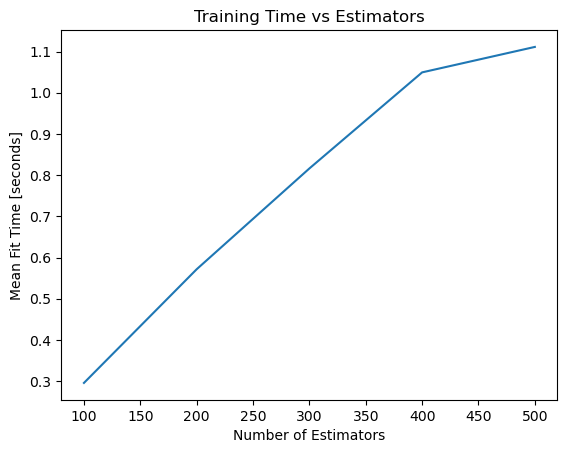

In [19]:
plt.plot(
    cv_results["param_randomforestclassifier__n_estimators"],
    cv_results["mean_fit_time"]
)
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators");

As the number of estimators increases, the training time generally increases. This is expected because more decision trees need to be constructed and fitted to the data.

**Task 2.7**: Evaluate the model performance.

Now that we have tuned the model using GridSearchCV, it's time to evaluate its accuracy on both the training and test datasets.

In [20]:
model_acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))

print("Model Training Accuracy: ", round(model_acc_train, 2))
print("Model Testing Accuracy: ", round(model_acc_train, 2))

Model Training Accuracy:  0.99
Model Testing Accuracy:  0.99


Both the **Training Accuracy** and **Testing Accuracy** are **0.99**, which indicates that the model is performing exceptionally well on both datasets. This suggests that the model generalizes well and isn’t overfitting.

### Evaluate

**Task 2.8**: Generate a detailed classification report that provides insights into the performance of the model.

In [21]:
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       176
           1       0.85      0.94      0.89       216

    accuracy                           0.88       392
   macro avg       0.88      0.87      0.87       392
weighted avg       0.88      0.88      0.87       392



**Key Metrics**

- **Precision**: It measures how many of the comments that the model classified as spam (class 1) were actually spam. High precision means fewer false positives, i.e., the model rarely misclassifies non-spam as spam.
- **Recall**: It measures how many actual spam comments (class 1) were correctly identified by the model. High recall means fewer false negatives, i.e., the model correctly identifies most spam comments.
- **F1-score**: It is the harmonic mean of precision and recall, providing a single metric that balances the two. A high F1-score indicates a good balance between precision and recall.
- **Support**: It is simply the number of actual occurrences of each class in the test data.

**Interpreting the Report**:

**Class 0 (Non-Spam)**:
- **Precision**: 0.92: Out of all the comments our model predicted as non-spam, 92% were actually non-spam.
- **Recall**: 0.80: Out of all actual non-spam comments, the model correctly identified 80%.
- **F1-score**: 0.85: This is the balance between precision and recall for non-spam. The model does well but misses 20% of non-spam comments (as indicated by recall).

**Class 1 (Spam)**:
- **Precision**: 0.85: Out of all comments our model classified as spam, 85% were actually spam. This means 15% of the time, the model misclassified non-spam as spam.
- **Recall**: 0.94: Out of all actual spam comments, the model correctly identified 94%. This is very high and indicates that only 6% of the spam comments were missed.
- **F1-score**: 0.89: This shows a very strong balance between precision and recall for spam comments.

**Summary**:
- **Non-Spam (Class 0)**: The model has high precision (92%) but lower recall (80%), meaning it's good at not misclassifying non-spam as spam but may miss some non-spam comments.
- **Spam (Class 1)**: The model does well with spam detection, having high recall (94%), meaning it catches most spam comments, but 15% of non-spam comments could be incorrectly flagged as spam (precision is 85%).

### Make Prediction Function

**Task 2.9**: Create a prediction function with threshold adjustment.

The function given below makes predictions about whether a comment is spam or not spam based on a given threshold for the predicted probability.

<div class="alert alert-block alert-info">
<strong>Info:</strong> A predict probability <strong>above 0.5</strong> corresponds to <strong>spam</strong> and <strong>below 0.5</strong> corresponds to <strong>not spam</strong>. If you believe the cost of letting spam go through (False Negatives) is higher, you could lower the 0.5 threshold to catch more potential spam. Conversely, if you're more concerned about blocking legitimate users' comments (False Positives), you can raise the threshold above 0.5. This will reduce the chances of mistakenly classifying legitimate comments as spam.
</div>

- **Threshold Adjustment**: This function introduces a customizable threshold (defaulting to 0.8). If the model predicts a probability higher than this threshold, the comment is classified as **Spam**. Otherwise, it’s labeled as **Not Spam**.
- **Predict Probability**: The model uses the predict_proba method to determine how likely it is that a comment belongs to the spam class (1). The probability is compared to the threshold to make the final classification.
- **Text Cleaning**: The input comment is first cleaned using the clean_comment function to ensure it’s in the right format for prediction.

This approach allows for tweaking the threshold to reduce misclassifications based on the specific requirements. For example, if your primary concern is ensuring that **legitimate users’ comments are not blocked**, this higher threshold might be helpful.

In [22]:
def make_prediction(raw_text, threshold=0.8):
    text = clean_comment(raw_text)
    prob = model.predict_proba([text])[0][1]
    if prob > threshold:
        result = "Spam"
    else:
        result = "Not Spam"
    return result

**Task 3.0**: Use the `make_prediction` function.

Here, the `make_prediction` function was called with the input "**he is back**". The result, '**Not Spam**', means that the predicted probability for this comment being classified as spam was lower than the specified threshold (default 0.8).

In [23]:
make_prediction("he is back")

'Not Spam'

## Save The Model

**Task 3.1**: Save the Trained Model Using Joblib.

In this step, we are saving the trained machine learning model to a file using the `joblib` library. This allows us to store the model and use it later without having to retrain it. 

The file will be saved with the name "spam_classifier_model.pkl", and we can load it later for making predictions or deploying it in applications like our [Streamlit web app](https://youtube-spam-comments-classifier-project.streamlit.app). 

This approach is particularly useful for deploying machine learning models in production environments, as it saves both time and computational resources.

In [24]:
import joblib
joblib.dump(model, "spam_classifier_model.pkl")

['spam_classifier_model.pkl']

***

*This project has been proudly contributed to the open-source community and is intended to serve as both an educational resource and a demonstration of the capabilities of machine learning in real-world applications. Whether you're here to learn, experiment, or build upon this work, we hope this project proves to be valuable.*

*This work is licensed under the [Apache License 2.0](https://github.com/neuraledgeai/YouTube_Spam_Comment_Classifier_Project/blob/main/LICENSE)*